# Explain Message Passing Neural Networks
A discussed in [our lecture](https://1drv.ms/b/s!AswJEkleh18Ah5QeJTjZ0V8fI0AJ-w?e=gsM2hK) and [Gilmer et al.](https://arxiv.org/abs/1704.01212), neural networks are composed of message passing, update, and readout functions. 
This notebook will demonstrate how to build these functions using Tensorflow.

In [1]:
import tensorflow 

2023-08-14 14:10:30.811815: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpnn.data import make_data_loader
from sklearn.metrics import r2_score
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np

## Get a Batch of Data
We are going to use same data loader functions from the previous notebooks to create a batch of training examples.

These functions are stored in the stripped-down MPNN library, [`mpnn`](./mpnn), I provide with these notebooks

In [3]:
loader = make_data_loader('datasets/train_data.proto', batch_size=32, output_property='g4mp2_atom', shuffle_buffer=10000)

2023-08-14 14:10:32.229217: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-14 14:10:32.248348: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-14 14:10:32.248485: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
inputs, outputs = next(iter(loader))
print(f'Produced a batch with the following tensors: {list(inputs.keys())}')

Produced a batch with the following tensors: ['atom', 'bond', 'connectivity', 'n_atom', 'n_bond', 'node_graph_indices', 'bond_graph_indices']


## Initial Processing: Embeddings
The `atom` and `bond` tensors contain the types of each atom and bond but are not particularly meaningful. 

In [5]:
inputs['atom']

<tf.Tensor: shape=(550,), dtype=int64, numpy=
array([2, 1, 1, 1, 1, 3, 2, 1, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 1, 3, 1, 3, 1, 0, 0, 0, 0, 0, 0,
       3, 1, 1, 1, 1, 1, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 3,
       1, 1, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 3, 1,
       1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 3, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 3, 1, 3, 1, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 3, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       1, 1, 1, 1, 1, 1, 1, 3, 0, 0, 0, 0, 1, 1, 1, 1, 1, 3, 1, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 1, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 1, 1, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 3, 1, 1, 3, 1, 2, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 1, 1, 2, 0, 0, 0, 0,
     

For example, the person who defined this file format and as a chemist, I know that atom type `1` is a Carbon and some information about how Carbon should behave.
The computer only sees discrete categories.
Our first step to building the network is to map these categories to features that could represent the data. 
A quick way to do that is to use ["embeddings"](https://towardsdatascience.com/neural-network-embeddings-explained-4d028e6f0526) that enable the machine learning model learn how these categories relate to each other automatically.

In [6]:
atom_embeddings = layers.Embedding(6, 2)  # Defines 6 categories of 2 features each
bond_embeddings = layers.Embedding(4, 2)

Note how the embedding maps our atom type to a 2 features.

Also, note that the the first rows three atoms are the same. These correspond to the same atoms which are all Carbons

In [7]:
atom_features = atom_embeddings(inputs['atom'])
bond_features = bond_embeddings(inputs['bond'])

In [8]:
atom_features.numpy()

array([[-3.9643906e-02,  8.1144273e-05],
       [-3.1701852e-02,  1.8164981e-02],
       [-3.1701852e-02,  1.8164981e-02],
       ...,
       [ 3.9830197e-02, -4.6492077e-02],
       [ 3.9830197e-02, -4.6492077e-02],
       [ 3.9830197e-02, -4.6492077e-02]], dtype=float32)

## Message Passing Steps
The core of a message passing network is to update the features describing the atoms, bonds or molecules using knowledge about how they are all connected.

We use ["gathering"](https://www.tensorflow.org/api_docs/python/tf/gather), ["reduction"](https://www.tensorflow.org/api_docs/python/tf/math/reduce_sum) and ["segmentation"](https://www.tensorflow.org/api_docs/python/tf/math#Segmentation) functions to express the update functions in Tensorflow.

Our first step is to gather all of the features for the atoms and the beginning at end fo the bonds

In [9]:
# `inputs['connectivity']` is the mapping of which atoms are bonded
source_atom = tf.gather(atom_features, inputs['connectivity'][:, 0])
target_atom = tf.gather(atom_features, inputs['connectivity'][:, 1])
print(f'Each array is a shape of {target_atom.shape} because we have {tf.reduce_sum(inputs["n_bond"])} bonds in this batch and 2 features per atom')

Each array is a shape of (1136, 2) because we have 1136 bonds in this batch and 2 features per atom


When then modify the features describing the "target" atom based on the bond by, simply, multiplying the features that describe the atom by the features of the bond

In [10]:
all_messages = tf.multiply(bond_features, target_atom)
all_messages

<tf.Tensor: shape=(1136, 2), dtype=float32, numpy=
array([[ 7.1985013e-04, -6.4775049e-05],
       [ 9.0018939e-04, -2.8935477e-07],
       [ 4.8698985e-04,  7.9676084e-04],
       ...,
       [ 4.8698985e-04,  7.9676084e-04],
       [ 4.8698985e-04,  7.9676084e-04],
       [ 7.0004974e-04,  2.8597002e-04]], dtype=float32)>

This new array is the messages from each each bond for each atom. 

We map it to a single message per atom using `segment_sum`.

In [11]:
messages = tf.math.segment_sum(all_messages, inputs['connectivity'][:, 0])
messages

<tf.Tensor: shape=(550, 2), dtype=float32, numpy=
array([[ 7.1985013e-04, -6.4775049e-05],
       [ 1.3871792e-03,  7.9647149e-04],
       [ 1.2438348e-03, -1.7296763e-03],
       ...,
       [ 4.8698985e-04,  7.9676084e-04],
       [ 4.8698985e-04,  7.9676084e-04],
       [ 7.0004974e-04,  2.8597002e-04]], dtype=float32)>

The message matrix now has only 37 rows, which corresponds to the number of atoms.

Our final step is to update the features for each atom using these messages

In [12]:
atom_features = atom_features + messages
atom_features

<tf.Tensor: shape=(550, 2), dtype=float32, numpy=
array([[-3.8924057e-02,  1.6369224e-05],
       [-3.0314673e-02,  1.8961452e-02],
       [-3.0458016e-02,  1.6435305e-02],
       ...,
       [ 4.0317185e-02, -4.5695316e-02],
       [ 4.0317185e-02, -4.5695316e-02],
       [ 4.0530246e-02, -4.6206109e-02]], dtype=float32)>

We now have new features for each atom and note how the first 3 rows are now different. Each atom now has new features because they were each bonded in different ways. 

## Final Step: Readout
Our last step is to take the features for each atom and use them to generate a single prediction per molecule. 

We use the "segment_sum" again, but this time to sum all features for each atom in each molecule rather than each message for each atom. The mapping of which atom belongs to what molecule is stored in `inputs['node_graph_indices']`

In [13]:
mol_features = tf.math.segment_sum(atom_features, inputs["node_graph_indices"])
mol_features

<tf.Tensor: shape=(32, 2), dtype=float32, numpy=
array([[-0.12330022, -0.08512788],
       [ 0.20064393, -0.4199011 ],
       [-0.04889973, -0.16560473],
       [ 0.09556329, -0.32166585],
       [ 0.12531716, -0.34301788],
       [ 0.06029863, -0.28374276],
       [ 0.10860047, -0.3117633 ],
       [ 0.18382528, -0.38919875],
       [ 0.2380191 , -0.5300516 ],
       [ 0.09105194, -0.25304687],
       [-0.14930196, -0.03971434],
       [ 0.08811323, -0.30790773],
       [ 0.14113611, -0.37719703],
       [ 0.08983947, -0.30458403],
       [-0.1474731 , -0.06770811],
       [ 0.04736888, -0.293624  ],
       [-0.06005651, -0.14531705],
       [-0.07673174, -0.14131266],
       [-0.13186587, -0.14341354],
       [-0.03648572, -0.20290396],
       [ 0.04575908, -0.29720995],
       [ 0.17298812, -0.4426319 ],
       [-0.00969008, -0.13235167],
       [ 0.17107397, -0.4211803 ],
       [ 0.00339112, -0.25858337],
       [-0.09762447, -0.22376896],
       [ 0.10849858, -0.3123156 ],
      

Great! We now have only two features per molecule. To map them to a single predicted value, we use a [Dense layer](https://keras.io/api/layers/core_layers/dense/).

In [14]:
output = layers.Dense(1, activation='linear')
mol_pred = output(mol_features)
mol_pred

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[ 0.00860583],
       [ 0.09361371],
       [ 0.02882135],
       [ 0.06803512],
       [ 0.07403214],
       [ 0.058496  ],
       [ 0.06695144],
       [ 0.08663299],
       [ 0.11720569],
       [ 0.05452579],
       [-0.00179087],
       [ 0.06491245],
       [ 0.08161967],
       [ 0.06438112],
       [ 0.00371966],
       [ 0.05958237],
       [ 0.02420585],
       [ 0.02237932],
       [ 0.01929655],
       [ 0.03679478],
       [ 0.0601716 ],
       [ 0.09624486],
       [ 0.02489327],
       [ 0.09198972],
       [ 0.05004757],
       [ 0.03694832],
       [ 0.06705143],
       [ 0.03361549],
       [ 0.09170231],
       [ 0.06803513],
       [ 0.07311872],
       [ 0.12895405]], dtype=float32)>

We are now down to a single prediction per molecule

## String it all together with Keras
The above cells show the computations that form an MPNN, but are not convenient to use. 
Keras [Layers](https://keras.io/api/layers/) and [Models](https://keras.io/api/models/) allow you to describe the computations and how they are connected to each other.

### Building Layers

Some of our steps above already using Keras layers (e.g., `Embedding`). Others use base Tensorflow operations, which we must combine to form Layers so that Keras can keep track of the computations for us.

We do that by implementing a new "Layer" in Keras. As describe in the [Keras docs](https://keras.io/guides/making_new_layers_and_models_via_subclassing/), these layers define the calculations performed for a certain step in network and, in many cases, the weights associated with the calculations. For simplicity, I do not add any training weights.

In [15]:
class MessagePassingLayer(layers.Layer):
    """Perform the message passing step"""

    def call(self, atom_features, bond_features, connectivity):
        """Perform the message passing steps.
        
        Takes the atom and bond features with the connectivity as inputs
        and produces a new set of atom features.
        """
        # Get the features for the atoms at each side of a bond
        source_atom = tf.gather(atom_features, connectivity[:, 0])
        target_atom = tf.gather(atom_features, connectivity[:, 1])

        # Make messages based on the "far side" of the bond and the bond type
        all_messages = tf.multiply(bond_features, target_atom)

        # Sum them up and add them to the original features
        messages = tf.math.segment_sum(all_messages, connectivity[:, 0])
        atom_features = atom_features + messages
        return atom_features

Run it to see how it behaves like our previous collection of 3 different cells!

In [16]:
mp = MessagePassingLayer()

In [17]:
mp(atom_features, bond_features, inputs["connectivity"])

<tf.Tensor: shape=(550, 2), dtype=float32, numpy=
array([[-3.8235705e-02, -5.1245981e-05],
       [-2.8962946e-02,  1.9682286e-02],
       [-2.9199850e-02,  1.4863526e-02],
       ...,
       [ 4.0804740e-02, -4.5029957e-02],
       [ 4.0804740e-02, -4.5029957e-02],
       [ 4.1232213e-02, -4.5974638e-02]], dtype=float32)>

The other base tensorflow method we need to wrap is `tf.math.segment_sum` when we use it to make the molecule property.


In [18]:
class Readout(layers.Layer):
    """Convert atomic to molecular features"""
    
    def call(self, atom_features, node_graph_indices):
        return tf.math.segment_sum(atom_features, node_graph_indices)

In [19]:
r = Readout()
r(atom_features, inputs["node_graph_indices"])

<tf.Tensor: shape=(32, 2), dtype=float32, numpy=
array([[-0.12330022, -0.08512788],
       [ 0.20064393, -0.4199011 ],
       [-0.04889973, -0.16560473],
       [ 0.09556329, -0.32166585],
       [ 0.12531716, -0.34301788],
       [ 0.06029863, -0.28374276],
       [ 0.10860047, -0.3117633 ],
       [ 0.18382528, -0.38919875],
       [ 0.2380191 , -0.5300516 ],
       [ 0.09105194, -0.25304687],
       [-0.14930196, -0.03971434],
       [ 0.08811323, -0.30790773],
       [ 0.14113611, -0.37719703],
       [ 0.08983947, -0.30458403],
       [-0.1474731 , -0.06770811],
       [ 0.04736888, -0.293624  ],
       [-0.06005651, -0.14531705],
       [-0.07673174, -0.14131266],
       [-0.13186587, -0.14341354],
       [-0.03648572, -0.20290396],
       [ 0.04575908, -0.29720995],
       [ 0.17298812, -0.4426319 ],
       [-0.00969008, -0.13235167],
       [ 0.17107394, -0.4211803 ],
       [ 0.00339112, -0.25858337],
       [-0.09762447, -0.22376896],
       [ 0.10849858, -0.3123156 ],
      

Also just like before!

### Stringing Layers together into a Model
The Keras Model lets us define how information flows from one step to another. We are going to make a function to describe how to connect layers using Keras's [functional API](https://keras.io/guides/functional_api/)

In [20]:
def make_model(num_features: int, num_messages: int):
    """Build an MPNN
    
    
    Args:
        num_features: Number of features to use to describe each atom and bond
        num_messages: Number of message passing steps
    Returns:
        Keras models that generate molecule property
    """
    
    # The first step is to define which inputs to expand and their shapes/types
    node_graph_indices = layers.Input(shape=(1,), name='node_graph_indices', dtype='int32')
    atom_types = layers.Input(shape=(1,), name='atom', dtype='int32')
    bond_types = layers.Input(shape=(1,), name='bond', dtype='int32')
    connectivity = layers.Input(shape=(2,), name='connectivity', dtype='int32')

    # Squeeze the node graph and connectivity matrices
    #  Keras makes all input arrays 2D, I find it easier to deal with them as 1D vectors
    #  The squeeze operation removes the second dimension, and I use Kera's Lambda layer
    #  to quickly wrap a simple Tensorflow function
    squeeze = layers.Lambda(tf.squeeze, arguments={'axis': 1}, name='squeeze')
    snode_graph_indices = squeeze(node_graph_indices)
    satom_types = squeeze(atom_types)
    sbond_types = squeeze(bond_types)
    
    # Generate initial features for each atom and bond using embeddings
    atom_features = layers.Embedding(6, num_features, name='atom_embedding')(satom_types)
    bond_features = layers.Embedding(4, num_features, name='bond_embedding')(sbond_types)
    
    # Perform a few message passing steps
    message_layer = MessagePassingLayer(name='message_passing')
    for _ in range(num_messages):
        atom_features = message_layer(atom_features, bond_features, connectivity)
        
    # Reduce to a single set of features per molecule
    mol_features = Readout(name='readout')(atom_features, snode_graph_indices)
    
    # Create the output layer
    output = layers.Dense(1, activation='linear', name='output')(mol_features)
    
    # Create the models by defining which layers are the inputs and which are the outputs
    model = Model(inputs=[node_graph_indices, atom_types, bond_types, connectivity], outputs=output)
    return model

Walk through this summary to make sure you understand it. It should be exactly the workflow that we have earlier.

In [21]:
model = make_model(16, 1)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 atom (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 bond (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 squeeze (Lambda)            (None,)                      0         ['node_graph_indices[0][0]',  
                                                                     'atom[0][0]',                
                                                                     'bond[0][0]']                
                                                                                              

Train it

In [22]:
model.compile(loss='mean_squared_error')
model.fit(loader, epochs=16)

Epoch 1/16


/home/lward/miniconda3/envs/mpnn/lib/python3.8/site-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['n_atom', 'n_bond', 'bond_graph_indices'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
2023-08-14 14:10:33.273298: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-14 14:10:33.274482: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1c0d4447c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-14 14:10:33.274492: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2023-08-14 14:10:33.277226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER

3298/3298 [==============================] - 6s 2ms/step - loss: 0.0086


2023-08-14 14:10:39.091029: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 15893200112292005993


Epoch 2/16
3298/3298 [==============================] - 5s 2ms/step - loss: 0.0029
Epoch 3/16
3298/3298 [==============================] - 6s 2ms/step - loss: 0.0025
Epoch 4/16
3298/3298 [==============================] - 6s 2ms/step - loss: 0.0022
Epoch 5/16
3298/3298 [==============================] - 6s 2ms/step - loss: 0.0020
Epoch 6/16
3298/3298 [==============================] - 6s 2ms/step - loss: 0.0019
Epoch 7/16
3298/3298 [==============================] - 5s 2ms/step - loss: 0.0018
Epoch 8/16
3298/3298 [==============================] - 6s 2ms/step - loss: 0.0017
Epoch 9/16
3298/3298 [==============================] - 6s 2ms/step - loss: 0.0016
Epoch 10/16
3298/3298 [==============================] - 5s 2ms/step - loss: 0.0015
Epoch 11/16
3298/3298 [==============================] - 6s 2ms/step - loss: 0.0015
Epoch 12/16
3298/3298 [==============================] - 6s 2ms/step - loss: 0.0015
Epoch 13/16
3298/3298 [==============================] - 5s 2ms/step - loss: 0.0015


See how we did

In [23]:
test_loader = make_data_loader('datasets/test_data.proto', batch_size=32, output_property='u0_atom')

In [24]:
y_true = np.hstack([x[1] for x in test_loader])  # Pulls data out of the data loader

In [25]:
y_pred = model.predict(test_loader)

408/408 [==============================] - 0s 770us/step


2023-08-14 14:12:05.410828: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 2225255850102577154
2023-08-14 14:12:05.410861: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 14549232867045753298
2023-08-14 14:12:05.410873: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 17509296337134286270


Text(0, 0.5, '$E_{atom}$, ML (Ha)')

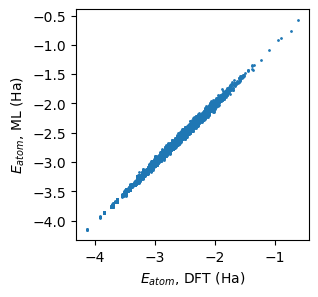

In [26]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(y_pred, y_true, s=1)
ax.set_xlabel('$E_{atom}$, DFT (Ha)')
ax.set_ylabel('$E_{atom}$, ML (Ha)')

Not bad for a model with 177 parameters!

In [27]:
r2_score(y_true, y_pred)

0.9925378191660429

In [28]:
np.abs(y_true - y_pred).mean()

0.42275015